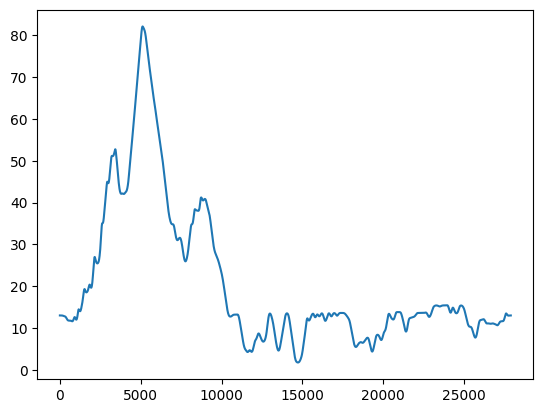

In [38]:
from activity_reader import *
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

activity = ActivityReader("Canopies_and_coastlines_time_trial.tcx")
activity.remove_unactive_period(2000)

sigma = 5
smoothed_elev = gaussian_filter1d(activity.elevation, sigma)

plt.plot(activity.distance, smoothed_elev)
plt.show()

In [39]:
def calculate_gradient(distance, elevation):
    gradient = []
    for i in range(len(distance)-1):
        delta_elevation = elevation[i] - elevation[i+1]
        delta_distance = distance[i] - distance[i+1]
        if delta_distance != 0:
            gradient.append(delta_elevation/delta_distance)
        else:
            gradient.append(0)
    gradient.append(0)
    return gradient

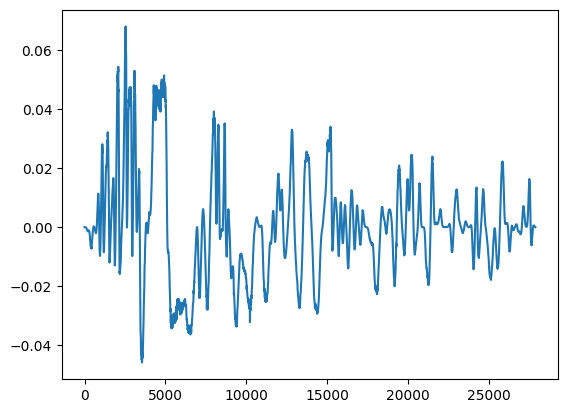

In [40]:
slope = calculate_gradient(activity.distance, smoothed_elev)
plt.plot(activity.distance, slope)
plt.show()

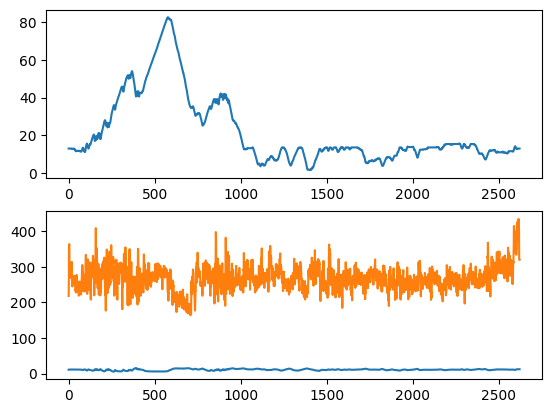

In [41]:
plt.subplot(2,1,1)
plt.plot(activity.elevation)

plt.subplot(2,1,2)
plt.plot(activity.speed)
plt.plot(activity.power)
plt.show()

In [42]:
#slope = [0.1]*200

In [43]:
import numpy as np
import control as ct 
import control.optimal as obc
import matplotlib.pyplot as plt


def bicycle_update(t, x, u, params={}):
    """Bicycle dynamics for control system.
    
    Parameters
    ----------
    x : array
            System state: [position, velocity, remaining anaerobic capacity]
    u : array
            System input: [power]

    Returns
    ----------
    float
        Bicycle acceleration 
    """
    

    # System parameters
    m = params.get('m', 85)
    g = params.get('g', 9.81)
    my = params.get('my', 0.004)
    b0 = params.get('b0', 0.091)
    b1 = params.get('b1', 0.0087)
    Iw = params.get('Iw', 0.14)
    r = params.get('r', 0.33)
    Cd = params.get('Cd', 0.7)
    rho = params.get('rho', 1.2)
    A = params.get('A', 0.4)
    eta = params.get('eta', 1)
    slope = params.get('slope')
    # w_prime = params.get('w_prime', 26630)
    # cp = params.get('cp', 265)

    # Variables for states and input
    v = x[1]
    #w_bal = x[2]
    power = u[0]
    
    #dw_bal = 0
    new = 0
    # if power < cp:
    #     new = w_prime - (w_prime - w_bal) * np.power(np.e, -(cp - power)/w_prime)
    #     dw_bal = w_bal + new
    # else:
    #     new = w_bal - (power - cp)
    #     dw_bal = w_bal - new
    

    dv = 1/v * 1/(m + Iw/r**2) * (eta*power - m*g*v*slope[int(t)] - my*m*g*v - b0*v - b1*v**2 - 0.5*Cd*rho*A*v**3)
    
    return np.array([v, dv])

def bicycle_output(t, x, u, params):
    return x

bicycle_system = ct.NonlinearIOSystem(bicycle_update, bicycle_output, states=2, name='bicycle', inputs=('u'), outputs=('p', 'v'))

In [44]:
# u = [630]*200 
# t = np.arange(200)
u = activity.power
t = activity.time

mass_bike = 8
mass_rider = 78

params = {
    'm': mass_bike + mass_rider,
    'slope': slope,
    'g': 9.81,
    'my': 0.004,
    'b0': 0.091,
    'b1': 0.0087,
    'Iw': 0.14,
    'rw': 0.33,
    'Cd': 0.7,
    'rho': 1.2,
    'A': 0.4,
    'eta': 1
}

response = ct.input_output_response(bicycle_system,  t, u, [0, 11.11], params)
t, y, u = response.time, response.outputs, response.inputs

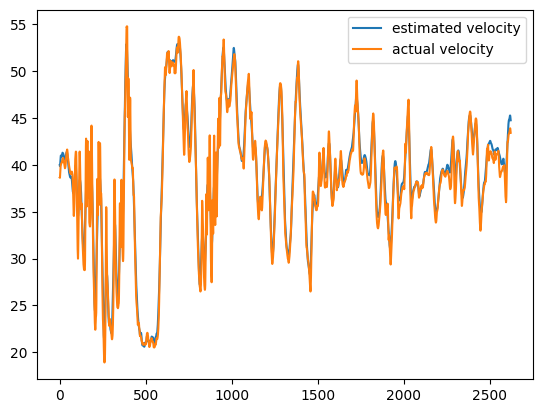

In [45]:
plt.plot(t, y[1]*3.6)
plt.plot(t, [elem*3.6 for elem in activity.speed])

plt.legend(["estimated velocity", "actual velocity"])
plt.show()

In [48]:
# A for time trial 
0.0293 * np.power(1.8, 0.725) * np.power(78, 0.425) + 0.0604

0.3462119563856737